In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/used-car-price-prediction-dataset/used_cars.csv
/kaggle/input/current-9-14-2nd-place-solution/__results__.html
/kaggle/input/current-9-14-2nd-place-solution/submission.csv
/kaggle/input/current-9-14-2nd-place-solution/__notebook__.ipynb
/kaggle/input/current-9-14-2nd-place-solution/__output__.json
/kaggle/input/current-9-14-2nd-place-solution/submission_1.csv
/kaggle/input/current-9-14-2nd-place-solution/custom.css
/kaggle/input/current-9-14-2nd-place-solution/__results___files/__results___21_1.png
/kaggle/input/current-9-14-2nd-place-solution/catboost_info/test_error.tsv
/kaggle/input/current-9-14-2nd-place-solution/catboost_info/learn_error.tsv
/kaggle/input/current-9-14-2nd-place-solution/catboost_info/catboost_training.json
/kaggle/input/current-9-14-2nd-place-solution/catboost_info/time_left.tsv
/kaggle/input/current-9-14-2nd-place-solution/catboost_info/learn/events.out.tfevents
/kaggle/input/current-9-14-2nd-place-solution/catboost_info/test/events.out.tfevents
/ka

In [2]:
import numpy as np 
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import re
import io
from copy import deepcopy
from IPython.display import display_html, clear_output
from gc import collect

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error, f1_score, r2_score, make_scorer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline

from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor, log_evaluation, early_stopping
import lightgbm as lgb

import os

import warnings
warnings.filterwarnings("ignore")

import optuna
from optuna.samplers import TPESampler
from optuna.pruners import HyperbandPruner

from tqdm import tqdm, trange
from tabulate import tabulate
from sklearn.base import clone

In [3]:
df_train = pd.read_csv("/kaggle/input/playground-series-s4e9/train.csv")
df_test = pd.read_csv("/kaggle/input/playground-series-s4e9/test.csv")
df_origin = pd.read_csv("/kaggle/input/used-car-price-prediction-dataset/used_cars.csv")
submission = pd.read_csv("/kaggle/input/playground-series-s4e9/sample_submission.csv")

In [4]:
sub_1 = pd.read_csv("/kaggle/input/current-9-14-2nd-place-solution/submission.csv")

In [5]:
# drop columns which not used
df_train.drop(columns=["id"], inplace=True)
df_test.drop(columns=["id"], inplace=True)

df_origin[['milage', 'price']] = df_origin[['milage', 'price']].map(
    lambda x: int(''.join(re.findall(r'\d+', x))))

df_train = pd.concat([df_train, df_origin], ignore_index=True)
df_train = df_train.drop_duplicates()

df_train.nunique()

brand             57
model           1898
model_year        34
milage          6652
fuel_type          7
engine          1146
transmission      62
ext_col          319
int_col          156
accident           2
clean_title        1
price           1569
dtype: int64

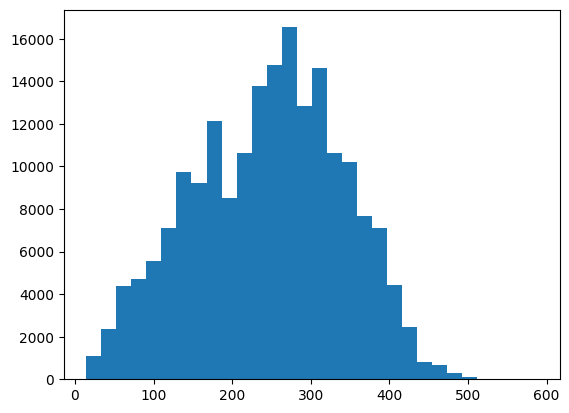

In [6]:
# df_train.copy(deep=True)

# Log transform the 'price' and 'milage' to reduce skewness
#df_train['milage'] = np.log1p(df_train['milage'])
#df_train['price'] = np.log1p(df_train['price'])

# df_train['milage_power'] = np.power(df_train['milage'])
# df_test['milage_power'] = np.power(df_test['milage'])
df_train['milage_box_cox'], _ = stats.boxcox(df_train['milage'])
df_test['milage_box_cox'], _ = stats.boxcox(df_test['milage'])
plt.hist(df_train['milage_box_cox'], bins=30)
plt.show()

In [7]:
# Define a function to remove outliers using the IQR method
# def remove_outliers(df, column):
#     Q1 = df[column].quantile(0.25)
#     Q3 = df[column].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# df_train = remove_outliers(df_train, 'milage')
# df_train = remove_outliers(df_train, 'milage_log')
# df_train = remove_outliers(df_train, 'price')
# df_train = remove_outliers(df_train, 'price_log')

In [8]:
df_train.groupby('engine').size().reset_index(name='count')

,engine,count
0,1.2L I3 12V GDI DOHC Turbo,27
1,1.3L I3 12V GDI DOHC Turbo,63
2,1.3L I3 12V MPFI DOHC Turbo,9
3,1.4L I4 16V GDI DOHC Turbo,13
4,1.5 Liter Turbo,8
...,...,...
1141,"Nettuno 3L V-6 port/direct injection, DOHC, va...",1
1142,Standard Range Battery,40
1143,V6,110
1144,V8,29


In [9]:
df_train.groupby('brand').agg(average_price=('price', 'mean')).sort_values(by='average_price', ascending=False).reset_index()

,brand,average_price
0,Bugatti,392274.375000
1,Lamborghini,163287.992814
2,Rolls-Royce,140017.575175
3,Bentley,129502.950337
4,McLaren,125434.642570
5,Ferrari,120860.105121
6,Aston,112467.886640
7,Rivian,81426.606260
8,Porsche,71231.781837
9,Lucid,64921.027778


In [10]:
def extract_age_features(df):
    current_year = 2024

    df['Vehicle_Age'] = current_year - df['model_year']
    df['Mileage_per_Year'] = df['milage'] / df['Vehicle_Age']
    df['milage_with_age'] =  df.groupby('Vehicle_Age')['milage'].transform('mean')
    df['Mileage_per_Year_with_age'] =  df.groupby('Vehicle_Age')['Mileage_per_Year'].transform('mean')
    #df['milage_brand'] =  df.groupby('brand')['milage'].transform('mean')
    return df

In [11]:
def extract_other_features(df):
    luxury_brands = ['Mercedes-Benz', 'BMW', 'Audi', 'Porsche', 'Land', 
                     'Lexus', 'Jaguar', 'Bentley', 'Maserati', 'Lamborghini', 
                     'Rolls-Royce', 'Ferrari', 'McLaren', 'Aston', 'Maybach']
    
    economy_brands = ['Saturn', 'MINI', 'Hummer', 'Scion']
    
    conditions = [
        df['brand'].isin(luxury_brands),  # condition for luxury brands
        df['brand'].isin(economy_brands)  # condition for economy brands
    ]
    
    choices = [0, 2]  # values corresponding to conditions
    
    # Assign values based on conditions, otherwise 1
    df['brand_category'] = np.select(conditions, choices, default=1)
    
    return df

In [12]:
def extract_engine_features(df):
    
#     def extract_horsepower(engine):
#         try:
#             return float(engine.split('HP')[0])
#         except:
#             return None

#     def extract_engine_size(engine):
#         try:
#             return float(engine.split(' ')[1].replace('L', ''))
#         except:
#             return None

#     def feature_extractor(df):
    df = df.copy()
    df['Horsepower'] = df['engine'].str.extract(r'([0-9]+\.[0-9]+)HP').astype(float)
    df['Engine_Size'] = df['engine'].str.extract(r'([0-9]+\.[0-9]+)L').astype(float)
    df['cylinder'] = df['engine'].str.extract(r'([0-9]+)\sCylinder').astype(float)
    df = df.drop('engine', axis=1)
#     return df
#     df['Horsepower'] = df['engine'].apply(extract_horsepower)
#     df['Engine_Size'] = df['engine'].apply(extract_engine_size)
#     df['Power_to_Weight_Ratio'] = df['Horsepower'] / df['Engine_Size']
    
    return df

In [13]:
def features_extraction(df):
#     df = extract_car_features(df)
    df = extract_engine_features(df)
#     df = extract_transmission_features(df)
    
    df = extract_age_features(df)
    df = extract_other_features(df)
    return df

In [14]:
%%time

train = features_extraction(df_train)
test = features_extraction(df_test)

CPU times: user 3.96 s, sys: 48.8 ms, total: 4.01 s
Wall time: 4.01 s


In [15]:
zero_count = (train == 0).sum()
print(zero_count)

brand                            0
model                            0
model_year                       0
milage                           0
fuel_type                        0
transmission                     0
ext_col                          0
int_col                          0
accident                         0
clean_title                      0
price                            0
milage_box_cox                   0
Horsepower                       0
Engine_Size                      0
cylinder                         0
Vehicle_Age                    168
Mileage_per_Year                 0
milage_with_age                  0
Mileage_per_Year_with_age        0
brand_category               83056
dtype: int64


In [16]:
train.head(10)

,brand,model,model_year,milage,fuel_type,transmission,ext_col,int_col,accident,clean_title,price,milage_box_cox,Horsepower,Engine_Size,cylinder,Vehicle_Age,Mileage_per_Year,milage_with_age,Mileage_per_Year_with_age,brand_category
0,MINI,Cooper S Base,2007,213000,Gasoline,A/T,Yellow,Gray,None reported,Yes,4200,445.971616,172.0,1.6,4.0,17,12529.411765,118194.992360,6952.646609,2
1,Lincoln,LS V8,2002,143250,Gasoline,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999,375.880055,252.0,3.9,8.0,22,6511.363636,118270.783105,5375.944687,1
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,A/T,Blue,Gray,None reported,Yes,13900,368.405334,320.0,5.3,8.0,22,6215.045455,118270.783105,5375.944687,1
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000,158.570811,420.0,5.0,8.0,7,2785.714286,67981.161419,9711.594488,1
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,7-Speed A/T,Black,Beige,None reported,Yes,97500,103.816798,208.0,2.0,4.0,3,2462.666667,29327.437406,9775.812469,0
5,Audi,A6 2.0T Sport,2018,40950,Gasoline,A/T,White,–,None reported,Yes,29950,218.803770,252.0,2.0,4.0,6,6825.000000,51718.760416,8619.793403,0
6,Audi,A8 L 3.0T,2016,62200,Gasoline,8-Speed A/T,Black,Black,None reported,Yes,28500,262.189517,333.0,3.0,6.0,8,7775.000000,76181.698869,9522.712359,0
7,Chevrolet,Silverado 1500 1LZ,2016,102604,E85 Flex Fuel,A/T,White,Gray,None reported,Yes,12500,325.477811,355.0,5.3,8.0,8,12825.500000,76181.698869,9522.712359,1
8,Ford,F-150 XLT,2020,38352,Gasoline,10-Speed Automatic,Snowflake White Pearl Metallic,Black,None reported,Yes,62890,212.678278,NaN,2.7,NaN,4,9588.000000,34436.373284,8609.093321,1
9,BMW,M4 Base,2015,74850,Gasoline,Transmission w/Dual Shift Mode,Black,Blue,None reported,Yes,4000,284.032398,425.0,3.0,6.0,9,8316.666667,82117.239132,9124.137681,0


                              price  Horsepower  Engine_Size  Vehicle_Age  \
price                      1.000000    0.277851     0.098717    -0.231040   
Horsepower                 0.277851    1.000000     0.606051    -0.406880   
Engine_Size                0.098717    0.606051     1.000000     0.001932   
Vehicle_Age               -0.231040   -0.406880     0.001932     1.000000   
Mileage_per_Year          -0.098486   -0.119912    -0.023382    -0.150068   
milage_with_age           -0.260909   -0.420373    -0.028052     0.939091   
Mileage_per_Year_with_age  0.143315    0.303634    -0.035367    -0.847575   

                           Mileage_per_Year  milage_with_age  \
price                             -0.098486        -0.260909   
Horsepower                        -0.119912        -0.420373   
Engine_Size                       -0.023382        -0.028052   
Vehicle_Age                       -0.150068         0.939091   
Mileage_per_Year                   1.000000        -0.115485   

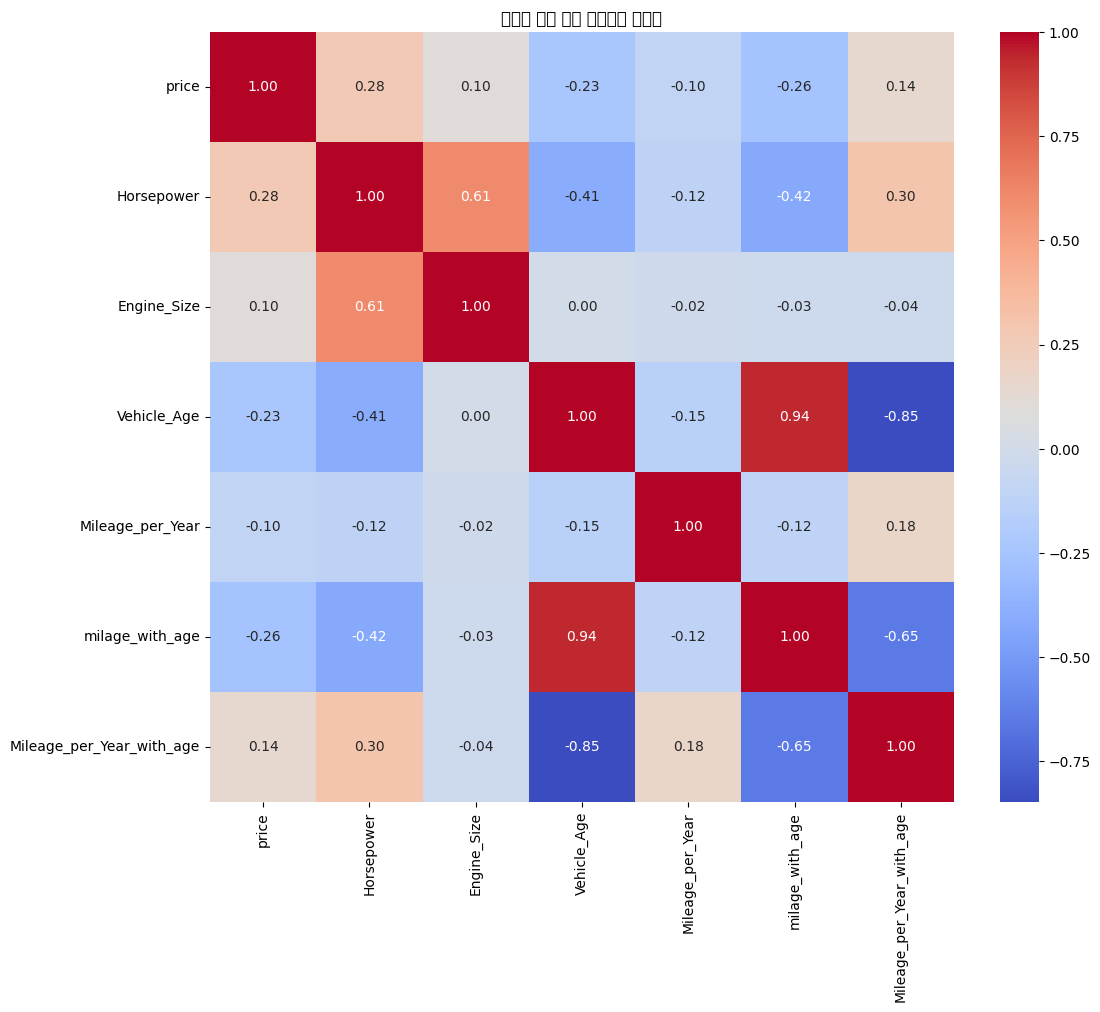

In [17]:
# 연속형 변수 목록
continuous_vars = [
    'price', 'Horsepower', 'Engine_Size', 
    'Vehicle_Age', 'Mileage_per_Year', 'milage_with_age',
    'Mileage_per_Year_with_age'
]

# 상관계수 행렬 계산
corr_matrix = train[continuous_vars].corr(method='pearson')

# 상관계수 행렬 출력
print(corr_matrix)

# 히트맵으로 상관관계 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('연속형 변수 간의 상관관계 히트맵')
plt.show()


In [18]:
def filter_cars(df):
    # Filter the DataFrame for rows where the 'brand' is 'Honda', 'Pontiac', or 'Subaru'
    filtered_df = df[df['brand'].isin(['Honda', 'Pontiac', 'Subaru','Mitsubishi', 'Saturn', 'MINI', 'Hummer', 'Scion'])]

    # Select the columns 'price', 'milage', and 'model_year'
    result = filtered_df[['brand', 'price', 'milage', 'model_year']]

    return result

# Example usage
output_df = filter_cars(df_train)
output_df.sort_values(by='price', ascending=False).head()

,brand,price,milage,model_year
160629,Honda,2954083,42653,2021
97654,Pontiac,2954083,64776,2001
143319,Mitsubishi,1950995,63750,2004
122696,Hummer,489995,2990,2023
1090,Subaru,479995,16146,2023


In [19]:
dash_count = (train == '–').sum()

print(dash_count)

brand                           0
model                           0
model_year                      0
milage                          0
fuel_type                     826
transmission                   91
ext_col                       381
int_col                      4660
accident                        0
clean_title                     0
price                           0
milage_box_cox                  0
Horsepower                      0
Engine_Size                     0
cylinder                        0
Vehicle_Age                     0
Mileage_per_Year                0
milage_with_age                 0
Mileage_per_Year_with_age       0
brand_category                  0
dtype: int64


In [20]:
# First fragment: Grouping by 'accident' and calculating the average price
df1 = df_train.groupby('accident').agg(average_price=('price', 'mean')).sort_values(by='average_price').reset_index()

# Second fragment: Counting the occurrences of 'accident' in the test dataframe
df2 = test.groupby('accident')['accident'].count().reset_index(name='count')

# Convert dataframes to HTML format
df1_html = df1.to_html()
df2_html = df2.to_html()

# Display the two dataframes side by side
display_html(df1_html + df2_html, raw=True)

,accident,average_price
0,At least 1 accident or damage reported,25415.110756
1,None reported,49036.909452
,accident,count
0,At least 1 accident or damage reported,27795
1,None reported,96263


In [21]:
def update(df):
    
    t = 100
    
    cat_c = ['brand','model','fuel_type','transmission','ext_col','int_col','accident','clean_title']
    re_ = ['model','transmission','ext_col','int_col']
    
    for col in re_:
        df.loc[df[col].value_counts(dropna=False)[df[col]].values < t, col] = "noise"
        
    for col in cat_c:
        # Replace '–' with a new category label, like 'Unknown'
        df[col] = df[col].replace('–', 'unknown')
        df[col] = df[col].fillna('unknown')
        df[col] = df[col].astype('category')
        
    return df

In [22]:
for col in ['Horsepower', 'Engine_Size', 'cylinder']:
    imputer = SimpleImputer()
    imputer.fit(pd.concat([train[[col]], test[[col]]]))
    train[col] = imputer.transform(train[[col]])
    test[col] = imputer.transform(test[[col]])

In [23]:
train['Power_to_Weight_Ratio'] = train['Horsepower'] / train['Engine_Size']
test['Power_to_Weight_Ratio'] = test['Horsepower'] / test['Engine_Size']

In [24]:
train  = update(train)
test   = update(test)

X = train.drop('price', axis=1)
y = train['price']

In [25]:
train.isna().sum()/len(train)*100

brand                        0.0
model                        0.0
model_year                   0.0
milage                       0.0
fuel_type                    0.0
transmission                 0.0
ext_col                      0.0
int_col                      0.0
accident                     0.0
clean_title                  0.0
price                        0.0
milage_box_cox               0.0
Horsepower                   0.0
Engine_Size                  0.0
cylinder                     0.0
Vehicle_Age                  0.0
Mileage_per_Year             0.0
milage_with_age              0.0
Mileage_per_Year_with_age    0.0
brand_category               0.0
Power_to_Weight_Ratio        0.0
dtype: float64

In [26]:
train.isna().sum(), test.isna().sum()

(brand                        0
 model                        0
 model_year                   0
 milage                       0
 fuel_type                    0
 transmission                 0
 ext_col                      0
 int_col                      0
 accident                     0
 clean_title                  0
 price                        0
 milage_box_cox               0
 Horsepower                   0
 Engine_Size                  0
 cylinder                     0
 Vehicle_Age                  0
 Mileage_per_Year             0
 milage_with_age              0
 Mileage_per_Year_with_age    0
 brand_category               0
 Power_to_Weight_Ratio        0
 dtype: int64,
 brand                        0
 model                        0
 model_year                   0
 milage                       0
 fuel_type                    0
 transmission                 0
 ext_col                      0
 int_col                      0
 accident                     0
 clean_title             

In [27]:
# Redirect the output of df_train.info() to a string buffer
buffer_train = io.StringIO()
train.info(buf=buffer_train)
info_train = buffer_train.getvalue()

# Redirect the output of test.info() to a string buffer
buffer_test = io.StringIO()
test.info(buf=buffer_test)
info_test = buffer_test.getvalue()

# Create HTML to display the two outputs side by side
info_train_html = f"<pre>{info_train}</pre>"
info_test_html = f"<pre>{info_test}</pre>"

# Display side by side using HTML
display_html(f"<div style='display:flex'><div style='margin-right: 20px;'>{info_train_html}</div><div>{info_test_html}</div></div>", raw=True)

RangeIndex: 192542 entries, 0 to 192541
Data columns (total 21 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 brand 192542 non-null category
 1 model 192542 non-null category
 2 model_year 192542 non-null int64 
 3 milage 192542 non-null int64 
 4 fuel_type 192542 non-null category
 5 transmission 192542 non-null category
 6 ext_col 192542 non-null category
 7 int_col 192542 non-null category
 8 accident 192542 non-null category
 9 clean_title 192542 non-null category
 10 price 192542 non-null int64 
 11 milage_box_cox 192542 non-null float64 
 12 Horsepower 192542 non-null float64 
 13 Engine_Size 192542 non-null float64 
 14 cylinder 192542 non-null float64 
 15 Vehicle_Age 192542 non-null int64 
 16 Mileage_per_Year 192542 non-null float64 
 17 milage_with_age 192542 non-null float64 
 18 Mileage_per_Year_with_age 192542 non-null float64 
 19 brand_category 192542 non-null int64 
 20 Power_to_Weight_Ratio 192542 non-null float64 
dtypes: category(8), float64(8), int64(5)
memory usage: 20.8 MB
 
RangeIndex: 125690 entries, 0 to 125689
Data columns (total 20 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 brand 125690 non-null category
 1 model 125690 non-null category
 2 model_year 125690 non-null int64 
 3 milage 125690 non-null int64 
 4 fuel_type 125690 non-null category
 5 transmission 125690 non-null category
 6 ext_col 125690 non-null category
 7 int_col 125690 non-null category
 8 accident 125690 non-null category
 9 clean_title 125690 non-null category
 10 milage_box_cox 125690 non-null float64 
 11 Horsepower 125690 non-null float64 
 12 Engine_Size 125690 non-null float64 
 13 cylinder 125690 non-null float64 
 14 Vehicle_Age 125690 non-null int64 
 15 Mileage_per_Year 125690 non-null float64 
 16 milage_with_age 125690 non-null float64 
 17 Mileage_per_Year_with_age 125690 non-null float64 
 18 brand_category 125690 non-null int64 
 19 Power_to_Weight_Ratio 125690 non-null float64 
dtypes: category(8), float64(8), int64(4)
memory usage: 12.6 MB

In [28]:
import numpy as np
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

callbacks = [log_evaluation(period=300), early_stopping(stopping_rounds=200)]

cat_cols = train.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"cat_cols--------{cat_cols}")


def get_MAE_oof(df, target, lgb_params, cat_params=None, model_type='LGBM'):

    
    oof_predictions = np.zeros(len(df))
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    models = []
    rmse_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(df)):
        print(f"Training fold {fold + 1}/{5} with {model_type}")

        X_train, X_val = df.iloc[train_idx], df.iloc[val_idx]
        y_train, y_val = target.iloc[train_idx], target.iloc[val_idx]

        if model_type == 'LGBM':
            train_data = lgb.Dataset(X_train, label=y_train)
            val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
            
            model = lgb.train(
                lgb_params,
                train_data,
                valid_sets=[train_data, val_data],
                valid_names=['train', 'valid'],
                callbacks=callbacks    
            )
        
        elif model_type == 'CAT':
            train_data = Pool(data=X_train, label=y_train , cat_features=cat_cols)
            val_data = Pool(data=X_val, label=y_val , cat_features=cat_cols )
            
            model = CatBoostRegressor(**cat_params)
            model.fit(train_data, eval_set=val_data, verbose=150, early_stopping_rounds=200)
        
        models.append(model)
        
        if model_type == 'LGBM':
            pred = model.predict(X_val, num_iteration=model.best_iteration)
        elif model_type == 'CAT':
            pred = model.predict(X_val)
        
        rmse = np.sqrt(mean_squared_error(y_val, pred))
        rmse_scores.append(rmse)

        print(f'{model_type} Fold RMSE: {rmse}')
        
        oof_predictions[val_idx] = pred
        
    print(f'Mean RMSE: {np.mean(rmse_scores)}')
    return oof_predictions, models


lgb_params = {
    'objective': 'MAE',
    'n_estimators': 1000,
    'random_state': 42,
}

oof_predictions_lgbm, models_lgbm = get_MAE_oof(X, y, lgb_params, model_type='LGBM')
X['LGBM_MAE'] = oof_predictions_lgbm


LGBM_preds = np.zeros(len(test))
for model in models_lgbm:
    LGBM_preds += model.predict(test) / len(models_lgbm)
test['LGBM_MAE'] = LGBM_preds


lgb_params = {
    'objective': 'MSE',
    'n_estimators': 1000,
    'random_state': 42,
}

oof_predictions_lgbm, models_lgbm = get_MAE_oof(X, y, lgb_params, model_type='LGBM')

X['LGBM_MSE_diff'] = oof_predictions_lgbm - X['LGBM_MAE']

LGBM_preds = np.zeros(len(test))
for model in models_lgbm:
    LGBM_preds += model.predict(test) / len(models_lgbm)
test['LGBM_MSE_diff'] = LGBM_preds - test['LGBM_MAE']

cat_cols--------['brand', 'model', 'fuel_type', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']
Training fold 1/5 with LGBM
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2124
[LightGBM] [Info] Number of data points in the train set: 154033, number of used features: 20
[LightGBM] [Info] Start training from score 30775.000000
Training until validation scores don't improve for 200 rounds
[300]	train's l1: 16353.9	valid's l1: 17245.4
Early stopping, best iteration is:
[252]	train's l1: 16411.6	valid's l1: 17244.1
LGBM Fold RMSE: 76047.17195768825
Training fold 2/5 with LGBM
[LightGBM] [Warning] Categoric

In [29]:
# lgb_params_1 ={

#     'learning_rate': 0.017521301504983752,
#     'max_depth': 42,
#     'reg_alpha': 0.06876635751774487, 
#     'reg_lambda': 9.738899198284985,
#     'num_leaves': 131,
#     'subsample': 0.2683765421728044,
#     'colsample_bytree': 0.44346036599709887,
#     'n_estimators': 1000,
#     'random_state': 42,
#     'extra_tree' : True,
#     'verbose' : -1
# }

# lgb_params_2 ={
    
#     "num_leaves": 426,
#     "max_depth": 20,
#     "learning_rate": 0.011353178352988012,
#     "n_estimators": 884,
#     "subsample": 0.5772552201954328,
#     "colsample_bytree": 0.9164865430101521,
#     "reg_alpha": 1.48699088003429e-06,
#     "reg_lambda": 0.41539458543414265,
#     "min_data_in_leaf": 73,
#     "feature_fraction": 0.751673655170548,
#     "bagging_fraction": 0.5120415391590843,
#     "bagging_freq": 2,
#     "min_child_weight": 0.017236362383443497,
#     "cat_smooth": 54.81317407769262,
#     "verbose" : -1,
#     "boosting_type" : "gbdt"
# }

# cat_params={
#     'learning_rate':0.042,
#     'iterations':1000,
#     'depth':10,
#     'random_strength' : 10,
#     'cat_features':cat_cols,
#     'l2_leaf_reg':0.3,
#     'random_seed':42,
#     'early_stopping_rounds': 200,
#     'task_type':'GPU',
# }

In [30]:
lgb_params_1 ={

    'learning_rate': 0.017521301504983752,
    'max_depth': 42,
    'reg_alpha': 0.06876635751774487, 
    'reg_lambda': 9.738899198284985,
    'num_leaves': 131,
    'subsample': 0.2683765421728044,
    'colsample_bytree': 0.44346036599709887,
    'n_estimators': 1000,
    'random_state': 42,
    'extra_tree' : True,
    'verbose' : -1
}

lgb_params_2 ={

    'learning_rate': 0.017521301504983752,
    'max_depth': 42,
    'reg_alpha': 0.06876635751774487, 
    'reg_lambda': 9.738899198284985,
    'num_leaves': 131,
    'subsample': 0.2683765421728044,
    'colsample_bytree': 0.44346036599709887,
    'n_estimators': 1000,
    'random_state': 42,
    'verbose' : -1
}

cat_params={
    'learning_rate':0.042,
    'iterations':1000,
    'depth':10,
    'random_strength' : 10,
    'cat_features':cat_cols,
    'l2_leaf_reg':0.3,
    'random_seed':42,
    'early_stopping_rounds': 200,
    'task_type':'GPU',
}


In [31]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores = []
rmse_scores_cat = []
LGBM_model=[]
CAT_model =[]

callbacks = [log_evaluation(period=150), early_stopping(stopping_rounds=200)]

for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
    
    model_1 = lgb.train(lgb_params_1,
                      train_data,
                      valid_sets=[train_data, val_data],
                      valid_names=['train', 'valid'],
                      callbacks=callbacks        
                      )
    model_2 = lgb.train(lgb_params_2,
                  train_data,
                  valid_sets=[train_data, val_data],
                  valid_names=['train', 'valid'],
                  callbacks=callbacks        
                  )
    
    LGBM_model.append(model_1)
    LGBM_model.append(model_2)

    y_pred = model_1.predict(X_val) * 0.5 + model_2.predict(X_val) * 0.5

    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_scores.append(rmse)
    
    print(f'LGBM Fold RMSE: {rmse}')
    
    model_cat = CatBoostRegressor(**cat_params)

    train_pool = Pool(X_train, y_train ,cat_features=cat_cols)
    val_pool = Pool(X_val, y_val , cat_features=cat_cols)
    model_cat.fit(train_pool, eval_set=val_pool, verbose=300)
    
    CAT_model.append(model_cat)
    y_pred_cat = model_cat.predict(X_val)
    rmse_cat = np.sqrt(mean_squared_error(y_val, y_pred_cat))
    rmse_scores_cat.append(rmse_cat)
    
    print(f'CAT Fold RMSE: {rmse_cat}')

print(f'Mean LGBM RMSE: {np.mean(rmse_scores)}')
print(f'Mean CAT RMSE: {np.mean(rmse_scores_cat)}')

Training until validation scores don't improve for 200 rounds
[150]	train's l2: 5.05881e+09	valid's l2: 5.65447e+09
[300]	train's l2: 4.90782e+09	valid's l2: 5.64407e+09
Early stopping, best iteration is:
[239]	train's l2: 4.96593e+09	valid's l2: 5.64221e+09
Training until validation scores don't improve for 200 rounds
[150]	train's l2: 4.42541e+09	valid's l2: 5.64663e+09
[300]	train's l2: 3.91098e+09	valid's l2: 5.63863e+09
[450]	train's l2: 3.54159e+09	valid's l2: 5.65229e+09
Early stopping, best iteration is:
[305]	train's l2: 3.89692e+09	valid's l2: 5.63762e+09
LGBM Fold RMSE: 75007.06476766075
0:	learn: 77819.5289663	test: 80567.2443676	best: 80567.2443676 (0)	total: 6.98s	remaining: 1h 56m 11s
300:	learn: 65619.3120384	test: 75334.1482797	best: 75189.5923289 (130)	total: 32.6s	remaining: 1m 15s
bestTest = 75189.59233
bestIteration = 130
Shrink model to first 131 iterations.
CAT Fold RMSE: 75189.59445667696
Training until validation scores don't improve for 200 rounds
[150]	train'

In [32]:
LGBM_preds = np.zeros(len(test))
for model in LGBM_model:
    LGBM_preds += model.predict(test) / len(LGBM_model)
    
CAT_preds = np.zeros(len(test))
for model in CAT_model:
    CAT_preds += model.predict(test) / len(CAT_model)

In [33]:
test_preds = LGBM_preds * 0.9 + CAT_preds * 0.1

In [34]:
submission['price'] = test_preds*0.5 + sub_1['price']*0.5
submission.to_csv("submission.csv", index=False)
submission.head()

,id,price
0,188533,18335.637220
1,188534,76987.113807
2,188535,55922.742079
3,188536,31204.520186
4,188537,30437.137928


In [35]:
feature_names = X.columns


lgb_importances = np.zeros(len(feature_names))

for model in LGBM_model:
    lgb_importances += model.feature_importance(importance_type='split') / len(LGBM_model)

lgb_feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': lgb_importances})
lgb_feature_importance.sort_values(by='Importance', ascending=False, inplace=True)


print(lgb_feature_importance)


                      Feature  Importance
15           Mileage_per_Year      2848.9
0                       brand      2496.8
21              LGBM_MSE_diff      2496.4
5                transmission      2234.0
3                      milage      1990.9
1                       model      1975.1
20                   LGBM_MAE      1727.5
19      Power_to_Weight_Ratio      1682.8
6                     ext_col      1674.6
7                     int_col      1415.8
10             milage_box_cox      1274.4
12                Engine_Size      1177.7
11                 Horsepower      1151.0
8                    accident      1043.9
18             brand_category       971.6
9                 clean_title       955.3
2                  model_year       944.5
16            milage_with_age       833.2
4                   fuel_type       800.8
17  Mileage_per_Year_with_age       735.9
14                Vehicle_Age       698.7
13                   cylinder       301.2


In [36]:
feature_names = X.columns
cat_importances = np.zeros(len(feature_names))

for model in CAT_model:
 
    cat_importances += model.get_feature_importance(type='FeatureImportance') / len(CAT_model)

cat_feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': cat_importances})
cat_feature_importance.sort_values(by='Importance', ascending=False, inplace=True)


print(cat_feature_importance)

                      Feature  Importance
20                   LGBM_MAE   15.615552
0                       brand    8.428114
5                transmission    8.322610
7                     int_col    7.521372
6                     ext_col    7.161792
21              LGBM_MSE_diff    6.502482
10             milage_box_cox    4.748443
1                       model    4.478128
8                    accident    4.209155
15           Mileage_per_Year    3.657888
4                   fuel_type    3.634251
3                      milage    3.367436
16            milage_with_age    3.231741
9                 clean_title    2.768777
14                Vehicle_Age    2.661875
12                Engine_Size    2.475711
13                   cylinder    2.445532
2                  model_year    2.210066
19      Power_to_Weight_Ratio    2.115097
11                 Horsepower    1.733546
18             brand_category    1.692448
17  Mileage_per_Year_with_age    1.017983


In [37]:
# %%time 

# class FtreMaker:
#     "This class makes new features using public discussions and kernel ideas"
    
#     def __init__(self):
#         self.fuel_type_dict = {
#             'Gasoline': 0,
#             'Hybrid': 1,
#             'E85 Flex Fuel': 2,
#             'uknown': 3,
#             'Diesel': 4,
#             'dash': 5,
#             'Plug-In Hybrid': 6,
#             'not supported': 7
#         }

#         self.accident_dict = {
#             'None reported': 0,
#             'At least 1 accident or damage reported': 1,
#             'uknown': 2
#         }

#         self.clean_title_dict = {
#             'Yes': 0,
#             'uknown': 1
#         }

#         self.expensive_ext_color = \
#         [  'Blue Caelum', 'Dark Sapphire', 'Bianco Monocerus', 'C / C', 'Ice',
#            'Tempest', 'Beluga Black', 'Bianco Icarus Metallic', 
#            'BLU ELEOS', 'Shadow Black', 'Nero Noctis', 'Sandstone Metallic',
#            'Lizard Green', 'Balloon White', 'Onyx', 'Donington Grey Metallic',
#            'China Blue', 'Diamond White', 'Rosso Corsa', 'Granite',
#            'Rosso Mars Metallic', 'Carpathian Grey', 'Kemora Gray Metallic',
#            'Grigio Nimbus', 'dash', 'Bianco Isis', 'Python Green', 'Fountain Blue',
#            'Custom Color', 'Vega Blue', 'Designo Magno Matte',
#            'Brands Hatch Gray Metallic', 'Rift Metallic', 'Gentian Blue Metallic',
#            'Arancio Borealis', 'BLUE', 'Aventurine Green Metallic', 'Apex Blue',
#            'Daytona Gray Pearl Effect', 'Daytona Gray Pearl Effect w/ Black Roof',
#            'Matte White', 'Carpathian Grey Premium Metallic', 'Blue Metallic',
#            'Santorini Black Metallic', 'Quartzite Grey Metallic',
#            'Carrara White Metallic', 'BLACK', 'Kinetic Blue', 'Nero Daytona'
#         ]

#         self.expensive_int_color = \
#         ['Dark Auburn', 'Hotspur', 'Cobalt Blue', 'Beluga Hide', 'Linen',
#          'Beluga', 'Black / Brown', 'Nero Ade', 'Sahara Tan', 'Portland']

#         self.expensive_hp = \
#         [443.0, 473.0, 493.0, 502.0, 521.0, 542.0, 
#          543.0, 571.0, 572.0, 573.0, 580.0,
#          591.0, 602.0, 611.0, 616.0, 620.0, 624.0, 
#          640.0, 641.0, 651.0, 710.0, 715.0, 760.0, 788.0, 797.0
#         ]
        
#         self.series_pattern = \
#         re.compile(r'^[A-Za-z0-9\-]+')
        
#         self.version_pattern = \
#         re.compile(r'([0-9]+\.[0-9]+[A-Za-z]*)|([A-Z]+[0-9]*)')
        
#         self.trim_pattern = \
#         re.compile(r'\b(Base|Sport|Premium|Ultimate|XLT|LZ|LT|Plus|Touring|SE|LE|Limited|Platinum|Performance|S|V6|GT|EX|SX|XLE|SR|SL|SV|XSE|TRD|RS|GranSport|Signature|Quad Cab|DRW|Cabriolet|Carbon Edition|Trail Boss|Prestige|Essence|Reserve|xDrive|4MATIC|PreRunner|EcoBoost|Scat Pack|Competition|Adventure Package|Laramie|Grand Touring|Long Range)\b')
        
#         self.hp_pattern = r'(\d+(\.\d+)?)HP'
#         self.displacement_pattern = r'(\d+\.\d+)L'
#         self.cylinder_pattern = r'(\d+) Cylinder'

#         self.engine_configs = {
#             'V6': 'V6', 
#             'V8': 'V8', 
#             'V10': 'V10', 
#             'V12': 'V12',
#             'Straight 6': 'Straight 6', 
#             'Flat 6': 'Flat 6', 
#             'I4': 'I4'
#         }

#         self.forced_induction = {'Turbo', 'Twin Turbo'}
#         self.valve_configs    = {'DOHC', 'SOHC', 'GDI', 'PDI'}
#         self.fuel_systems     = {'MPFI', 'GDI', 'PDI', 'TFSI'}
        
#     def fit(self, X: pd.DataFrame, y = None, **params):
#         return self
    
#     def _make_mdlparts(self, model: str):
#         "This method extracts model components"
        
#         series  = self.series_pattern.search(model)
#         version = self.version_pattern.search(model)
#         trim    = self.trim_pattern.search(model)

#         return {
#             'Series'  : series.group(0) if series else "uknown",
#             'Version' : version.group(0) if version else "uknown",
#             'Trim'    : trim.group(0) if trim else "uknown"
#         }
    
#     def _parse_engine(self, engine_desc):
#         "This metod processes the engine description feature and returns sub-parts"
        
#         int_default_na = -1
#         obj_default_na = "uknown"
        
#         features = {
#             'horsepower': int_default_na, 
#             'displacement': int_default_na, 
#             'cylinder_count': int_default_na,
#             'engine_configuration':obj_default_na, 
#             'forced_induction': obj_default_na,
#             'valve_configuration': obj_default_na, 
#             'fuel_system': obj_default_na, 
#             'mild_hybrid': False,
#         }
        
#         patterns = {
#             'horsepower'    : (self.hp_pattern, lambda x: float(x)),
#             'displacement'  : (self.displacement_pattern, lambda x: float(x)),
#             'cylinder_count': (self.cylinder_pattern, lambda x: int(x)),
#         }
        
#         for feature, (pattern, convert) in patterns.items():
#             match = re.search(pattern, engine_desc)
#             if match:
#                 try:
#                     features[feature] = convert(match.group(1))
#                 except ValueError:
#                     pass  
        
#         features['engine_configuration'] = \
#         next((config for config, name in self.engine_configs.items() if config in engine_desc), 
#              obj_default_na
#             )
        
#         features['forced_induction'] = \
#         next((induction for induction in self.forced_induction if induction in engine_desc),
#              obj_default_na
#             )
        
#         features['valve_configuration'] = \
#         next((valve for valve in self.valve_configs if valve in engine_desc), 
#              obj_default_na
#             )
        
#         features['fuel_system'] = \
#         next((system for system in self.fuel_systems if system in engine_desc), 
#              obj_default_na
#             )
        
#         features['mild_hybrid'] = 'Mild Electric Hybrid' in engine_desc
        
#         return features
    
#     def _get_gear_number(self, trans):
#         match = re.search(r'(\d+)[-\s]?Speed', trans)
#         return int(match.group(1)) if match else -1

#     def _get_transmission_type(self, trans):
#         if 'A/T' in trans or 'Automatic' in trans:
#             return 'Automatic'
#         elif 'M/T' in trans or 'Manual' in trans:
#             return 'Manual'
#         elif 'CVT' in trans:
#             return 'CVT'
#         elif 'DCT' in trans:
#             return 'DCT'
#         else:
#             return 'Other'

#     def _get_special_features(self, trans):
#         features = []
#         if 'Dual Shift Mode' in trans:
#             features.append('Dual Shift Mode')
#         if 'Auto-Shift' in trans:
#             features.append('Auto-Shift')
#         if 'Overdrive' in trans:
#             features.append('Overdrive')
#         if 'Electronically Controlled' in trans:
#             features.append('Electronically Controlled')
#         if 'Variable' in trans:
#             features.append('Variable')
#         return ', '.join(features) if features else "uknown"

#     def _get_transmission_dsg(self, trans):
#         if 'A/T' in trans:
#             return 'A/T'
#         elif 'M/T' in trans:
#             return 'M/T'
#         elif 'CVT' in trans:
#             return 'CVT'
#         elif 'DCT' in trans:
#             return 'DCT'
#         else:
#             return "uknown"

#     def transform(self, X: pd.DataFrame, y = None, **params):
#         "This method makes new features from the existing dataset"

#         df_train = X.copy()
#         print(f"\n\n---> Starting shape = {df_train.shape}")
        
#         print(f"---> Imputing category columns")
#         cat_ftre     = df_train.select_dtypes("object").columns
#         df_train[cat_ftre] = df_train[cat_ftre].fillna("uknown")
        
#         print(f"---> Performing -150 feature transforms")
#         df_train['fuel_type_encoded']   = df_train['fuel_type'].map(self.fuel_type_dict)
#         df_train['accident_encoded']    = df_train['accident'].map(self.accident_dict)
#         df_train['clean_title_encoded'] = df_train['clean_title'].map(self.clean_title_dict)
        
#         df_train['expensive_color_ext_encoded'] = \
#         df_train.ext_col.isin(self.expensive_ext_color).astype(int)
        
#         df_train['expensive_color_int_encoded'] = \
#         df_train.int_col.isin(self.expensive_int_color).astype(int)
        
#         df_train['expensive_hp'] = \
#         df_train['engine'].str.extract(r'(\d+\.?\d*)HP').\
#         astype(float).isin(self.expensive_hp).\
#         astype(int)
        
#         df_train['cylinder'] = \
#         df_train['engine'].str.extract(r'(\d+\.?\d*) Cylinder').astype(float) 
        
#         df_train['got_V'] = df_train['model'].str.extract(r'(\d+\.?\d*) V').notna().astype(int)
        
#         print(f"---> Making car model components")
#         mdlparts = df_train['model'].apply(self._make_mdlparts).apply(pd.Series)
#         df_train       = pd.concat([df_train, mdlparts], axis=1)
#         del mdlparts
        
#         print(f"---> Making engine components")
#         unique_engines  = df_train['engine'].unique()
#         engine_features = [self._parse_engine(engine) for engine in unique_engines]
#         engine_features = pd.DataFrame(engine_features, index = unique_engines).reset_index()
#         engine_features.rename(columns={'index': 'engine'}, inplace=True)
        
#         df_train = df_train.merge(engine_features, how = "left", on = "engine")
#         del engine_features,unique_engines
 
#         print(f"---> Making transmission components")
#         df_train['nb_gears']   = \
#         df_train['transmission'].apply(self._get_gear_number)
#         df_train['transmission_mode'] = \
#         df_train['transmission'].apply(self._get_transmission_type)
#         df_train['transmission_special']  = \
#         df_train['transmission'].apply(self._get_special_features)
#         df_train['transmission_dsg'] = \
#         df_train['transmission'].apply(self._get_transmission_dsg)
        
#         print(f"---> Imputing all numeric and categorical features at the end")
#         num_ftre = df_train.select_dtypes(include=[np.number]).columns
#         cat_ftre = df_train.select_dtypes(include=['object']).columns
        
#         df_train[num_ftre] = df_train[num_ftre].fillna(-1)
#         df_train[cat_ftre] = df_train[cat_ftre].fillna("uknown").astype("category")
        
# #       df_train["Source"] = df_train["Source"].astype(str)
  
#         print(f"\n---> Final shape = {df_train.shape}")
#         return df_train